# Giant Molecular Clouds density structure <a class="anchor" id="toc"></a>

1. [Workflow](#workflow)
    1. [Mass-bounded extractions](#massbound)
    2. [Volume-bounded extractions](#volumebound)
2. [CO SLED of a GMC](#cosled)
    1. [Extracting the clumps SLEDs](#extract)
    2. [Plotting the GMC CO SLED in flux units](#gmcplot)
    3. [Plotting the GMC CO SLED in luminosities](#gmcplot_lum)
    4. [Exporting the GMC CO SLEDs in luminosities](#exportSLED)
    5. [A faster way to extract interpolated CO SLEDs](#fastinterp)
    6. [UPDATE: Cloudy-sampled hden now starts from 0 instead of 1](#new_hden)
    7. [PROBLEM: New turbogrid has problematic edges](#new_grid)
3. [Looking for CO(1-0) luminosity](#CO1)
4. [Looking for a different clumps mass](#clump_mass)
5. [Which clump dominates the CO SLED?](#clump_dom)
6. [Adding diffuse ICM to the GMC](#diffuse)

The PDF (probability distribution function) of gas density $\rho$, in a supersonically turbulent, isothermal cloud of mean density $\rho_0$, is (Vallini et al., 2017):

$\Large
g_s ds = \frac{1}{\sqrt{(2 \pi \sigma_s^2)}}
\exp \left[ -\frac{1}{2} \left( \frac{s-s_0}{\sigma_s} \right)^2 \right] 
\; \mbox{with} \; s = \ln \left( \frac{\rho}{\rho_0} \right)
\; , \; s_0 = -\frac{\sigma_s^2}{2}
\; , \; \sigma_s^2 = \ln \left( 1 + b^2 \mathcal{M}^2 \frac{\beta}{\beta+1} \right)
$

where the standard deviation of the distribution, $\sigma_s$, 
depends on the sonic Mach number $\mathcal{M}$,
the ratio between thermal and magnetic pressure $\beta$
and the $b$ factor, which parametrizes the kinetic energy injection mechanism 
(often referred to as forcing) driving the turbulence
($b \approx 0.3 - 1$)

A cloud with gas density $n$ has an associated Jeans radius $R_J$ that depends on the sound speed $c_s$, which in turn depends only on the gas temperature $T$ if we assume the fluid to be adiabatic. The Jeans mass $M_J$ then is simply the density divided by the volume.

$$\large
R_J(n) = \sqrt{\frac{\pi c_s^2}{G \rho}} = \sqrt{\frac{\pi c_s^2}{G \mu m_p n}}
\; , \; \mbox{where} \; \;
c_s = \sqrt{\left(\frac{\partial P}{\partial \rho} \right)_S} = \sqrt{\gamma \frac{P}{\rho}} =
\sqrt{\gamma \frac{k T}{\mu m_p}}
$$

In [10]:
from gmc_module import *

***

# Vallini et al. 2018 workflow <a class="anchor" id="workflow"></a>
([back to top](#toc))

1. We assume a GMC with a certain T, R and mean density n0
2. We calculate the sound speed, the volume and the mass
3. Within a `while` loop, we extract densities from a lognormal distribution
4. We calculate the Jeans radius, the Jeans mass and the associated column density
5. We stop when the total mass reaches the GMC mass calculated at point 2

GMC models from Vallini et al. 2017 (Table 1) plus the fiducial one from Vallini et al. 2019:

| Model | $M_{GMC} (M_{\odot})$ | $r_{GMC} (pc)$ | $\rho_0 (g/cm^{3})$   | $\mathcal{M}$ | $n_0 (cm^{-3})$ | $N_{clumps}$ |
| ----- | :-------------------: | :------------: | :-------------------: | :----: | :------------:  | :----: |
| A     | $6.2 \times 10^3$     | $4$            | $8.2 \times 10^{-22}$ | $10$   | $401.8$         | $122$   |
| B     | $9.9 \times 10^4$     | $16$           | $2.1 \times 10^{-22}$ | $20$   | $102.9$         | $1178$  |
| C     | $3.9 \times 10^6$     | $100$          | $3.3 \times 10^{-23}$ | $50$   | $16.2$          | $22463$ |
| V19   | $1.0 \times 10^5$     | $15$           | $6.1 \times 10^{-22}$ | $10$   | $300.0$         | $1555$  |

In [12]:
len(hden) * len(logFX) + 675

1242

***

# Mass-bounded extractions <a class="anchor" id="massbound"></a>
([back to top](#toc))

We extract clumps densities from the lognormal PDF.

&rarr; We keep the extracted density $n$ only if $n > n_0$.

&rarr; The stopping condition is the total **mass** of the clumps, calculated with the free parameters above.

&rarr; At the end the mass and the volume of the sum of the clumps are compared to the GMC values

In [1]:
from gmc_module import *

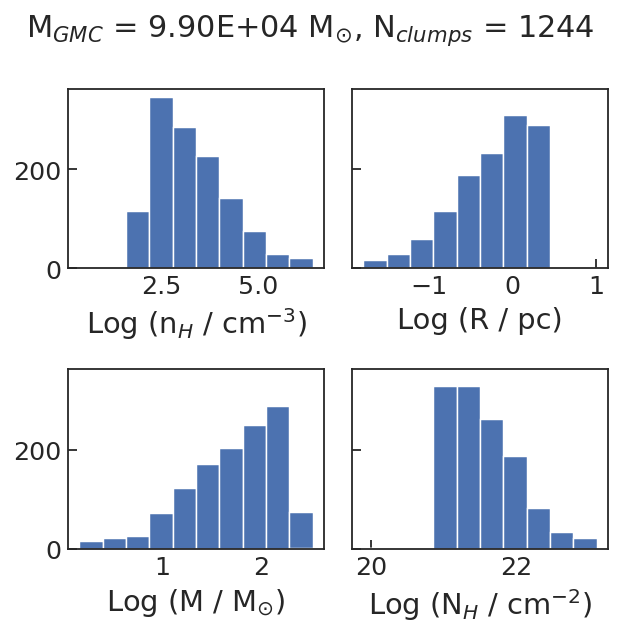

In [8]:
gmc = gmcB
ndf = gmc.extract_clumps()
ndf_histo(ndf)

The output of this extractions is the 4 arrays, histogrammed here above:
1. the gas density $n_H$ of every clump within the GMC
2. the Jeans radius $R$ of the clump
3. the Jeans mass $M$ of the clump
4. the column density $N_H = n_H \times R$

Those can be saved in a pandas dataframe `ndf`, with all the quantities in log scale, R in pc, M in Msun and densities in cgs

In [80]:
ndf.T

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
hden,2.522576,3.642516,2.714387,2.886275,3.587006,4.545128,3.275534,3.041442,2.694764,3.265600,...,4.223788,4.198861,3.691494,4.504230,3.522560,2.616726,3.842990,4.818190,3.734202,1.655171
logR,0.456940,-0.103030,0.361034,0.275090,-0.075275,-0.554336,0.080461,0.197507,0.370846,0.085428,...,-0.393666,-0.381202,-0.127519,-0.533887,-0.043052,0.409865,-0.203267,-0.690867,-0.148873,0.471248
logM,2.994572,2.434602,2.898666,2.812722,2.462356,1.983296,2.618092,2.735139,2.908477,2.623059,...,2.143965,2.156429,2.410112,2.003744,2.494579,2.947497,2.334365,1.846765,2.388758,2.170091
logNH,21.468912,22.028882,21.564818,21.650762,22.001127,22.480188,21.845391,21.728345,21.555006,21.840424,...,22.319518,22.307055,22.053371,22.459739,21.968904,21.515987,22.129119,22.616719,22.074725,20.615816


***

# Volume-bounded extractions <a class="anchor" id="volumebound"></a>
([back to top](#toc))

We extract clumps densities from the lognormal PDF.

&rarr; We keep the extracted density $n$ only if $n > n_0$.

&rarr; The stopping condition is the total **volume** of the GMC, calculated with the free parameters above.

&rarr; At the end the mass and the volume of the sum of the clumps is compared to the GMC

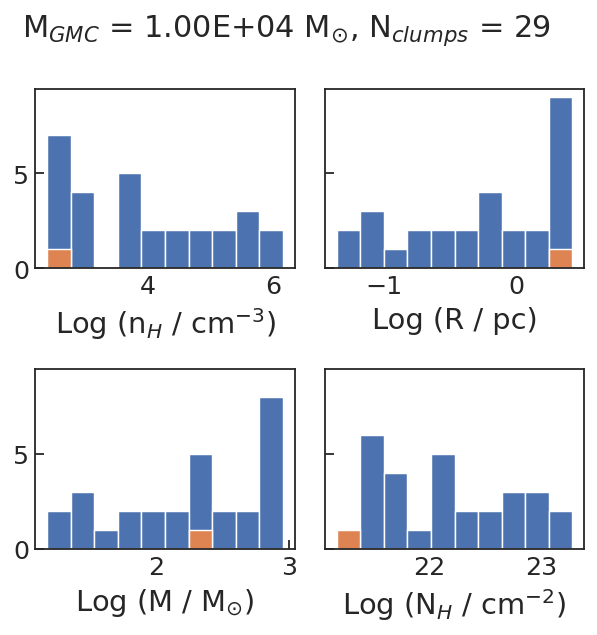

In [83]:
gmc = GMC('Pippo', M=1e4, R=5, rho0=mu*mp*300, Mach=50, T=10)
ndf = gmc.extract_clumps(Rclump='jeans', bound='volume', save=False)
ndf_histo(ndf)

***

# CO SLED of a GMC <a class="anchor" id="cosled"></a>
([back to top](#toc))

## Extracting the clumps SLEDs <a class="anchor" id="extract"></a>
([back to top](#toc))

In [321]:
# CLOUDY simulations parameters
wd1, wd2 = ['/media/phd/cloudy/' + x + '/' for x in ['hagrid', 'ngmgrid']]
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)

# list the available extractions
for d in next(os.walk('./extractions/'))[1]: print(d)

# choose GMC extractions and Cloudy grid
ndf_name = 'GMC_n401_R4pc_M10_10K'
#ndf = pd.read_csv('./extractions/' + ndf_name + '/' + ndf_name + '.csv')
ndf = pd.read_csv('./extractions/' + ndf_name + '.csv')
wd = wd2

GMC_n102_R16pc_M20
GMC_n102_R16pc_M10
GMC_n401_R4pc_M10
GMC_n300_R15pc_M10_20K
GMC_n16_R100pc_M50_10K


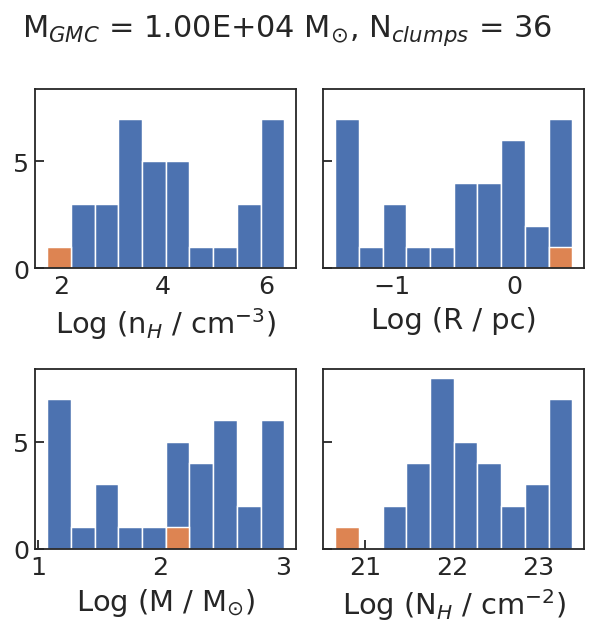

In [1]:
from gmc_module import *
gmc = GMC('Adam', M=1e4, R=5, rho0=mu*mp*300, Mach=50, T=10)
ndf = pd.read_csv(gmc.ndf)
ndf_histo(ndf)

In [35]:
# PDR
ndf = pd.read_csv(gmc.ndf)
Jmax = 30
wd = '/media/phd/cloudy/ngmgrid/'
pbar = ProgressBar()
for k in pbar(range(len(ndf))):
    # dataframe for save_csv of this extraction's CO SLED
    extract = pd.DataFrame(index=gnames[::-1], columns=['CO' + str(c) for c in np.arange(1,Jmax+1)])
    # take values from the PDF extraction 
    logn = ndf.loc[k, 'hden']
    logNH = ndf.loc[k, 'logNH']
    # list inferior and superior closest log(n)
    hh = [hden[hden < logn].max(), hden[hden > logn].min()]
    for g in gnames:
        # for every G0: list the 2 files for the 2 closest gas densities
        ff = ['pdr_h' + ('%.2f' % h).replace('.', '') + '_' + g for h in hh]
        # for those 2 nH: generate interpolated (logNH, G0 if needed) SLED
        Hsleds = np.array([sww_check(wd, fname, logNH, Jmax=Jmax)[2] for fname in ff])
        # interpolated (logn) SLED
        thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn, Jmax=Jmax)
        extract.loc[g] = np.array(thisSLED)
    extract.to_csv(gmc.ndf.replace('.csv', '_') + 'PDR{:04d}'.format(k) + '.csv')

100% |#########################################################################|


In [3]:
# XDR
ndf = pd.read_csv(gmc.ndf)
Jmax=30
wd = '/media/phd/cloudy/ngmgrid/'
pbar = ProgressBar()
for k in pbar(range(len(ndf))):
    # dataframe for save_csv of this extraction's CO SLED
    extract = pd.DataFrame(index=xnames[::-1], columns=['CO' + str(c) for c in np.arange(1,Jmax+1)])
    # take values from the PDF extraction 
    logn = ndf.loc[k, 'hden']
    logNH = ndf.loc[k, 'logNH']
    # list inferior and superior closest log(n)
    hh = [hden[hden < logn].max(), hden[hden > logn].min()]
    for x in xnames:
        # for every FX: list the 2 files for the 2 closest gas densities
        ff = ['xdr_h' + ('%.2f' % h).replace('.', '') + '_' + x for h in hh]
        # for those 2 nH: generate interpolated (logNH, G0 if needed) SLED
        Hsleds = np.array([sww_check(wd, fname, logNH, Jmax=Jmax)[2] for fname in ff])
        # interpolated (logn) SLED
        thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn, Jmax=Jmax)
        extract.loc[x] = np.array(thisSLED)
    extract.to_csv(gmc.ndf.replace('.csv', '_') + 'XDR{:04d}'.format(k) + '.csv')

100% |#########################################################################|


## Plotting the GMC CO SLED in flux units <a class="anchor" id="gmcplot"></a>
([back to top](#toc))

In [14]:
from gmc_module import *
gmc = GMC('Adam', M=1e4, R=5, rho0=mu*mp*300, Mach=50, T=10)

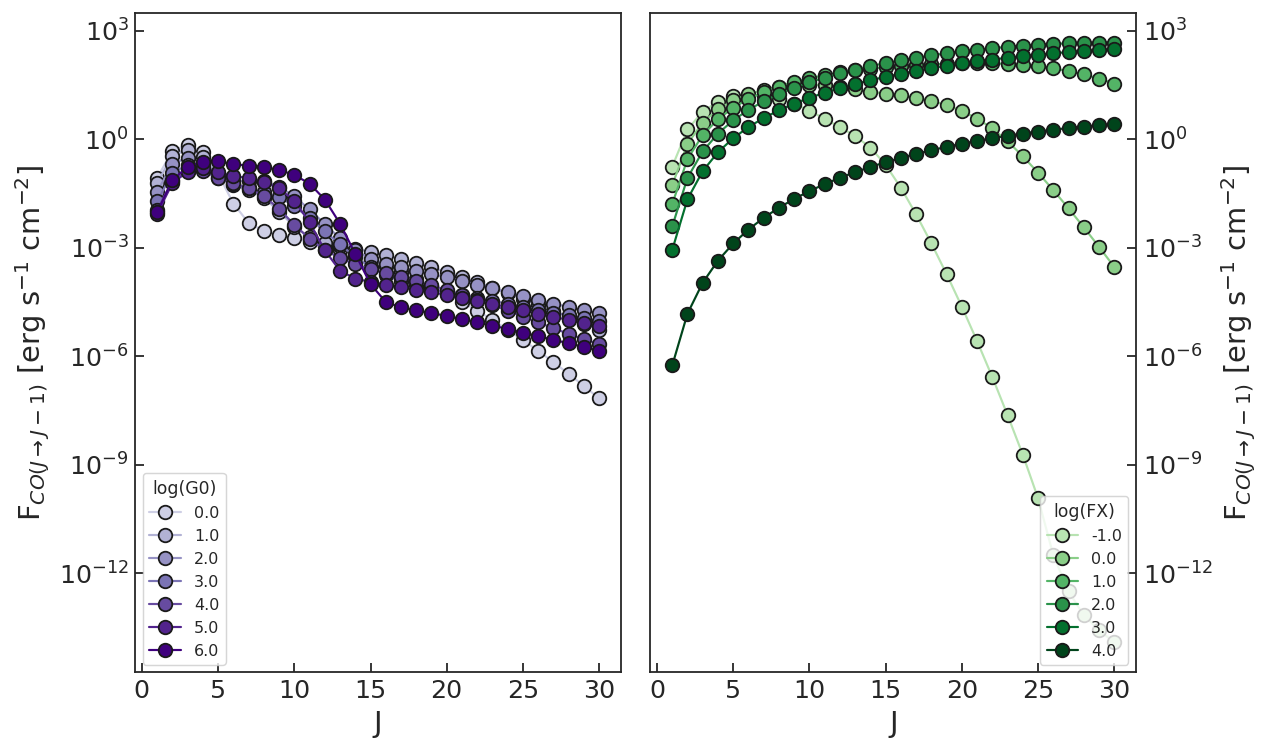

In [15]:
pdr_gmc, xdr_gmc = gmc.pdr_xdr(units='flux')

# 0 if no normalization, 1 for CO(1-0), 6 for CO(6-5), etc
norm = 0
Jmax = 30
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)

color = cm.Purples(np.linspace(0.3, 1, len(pdr_gmc.index[::4])))
for g, c in zip(pdr_gmc.index[::4], color):
    if norm: denom = pdr_gmc.loc[g, pdr_gmc.columns[norm-1]]
    else: denom = 1.
    ax1.plot(np.arange(1,Jmax+1), pdr_gmc.loc[g]/denom,
            marker='.', ms=15, mec='k', color=c,
            label=float(g[1:])/1e2)
ax1.legend(title='log(G0)', loc='lower left')

color = cm.Greens(np.linspace(0.3, 1, len(xdr_gmc.index[::4])))
for x, c in zip(xdr_gmc.index[::4], color):
    if norm: denom = xdr_gmc.loc[x, xdr_gmc.columns[norm-1]]
    else: denom = 1.
    ax2.plot(np.arange(1,Jmax+1), xdr_gmc.loc[x]/denom,
            marker='.', ms=15, mec='k', color=c,
            label=float(x[1:])/1e2)
ax2.legend(title='log(FX)', loc='lower right')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.yaxis.set_tick_params(labelright=True)

for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0,Jmax+1,5))
    ax.set_yscale('log')
    ax.set_xlabel('J')
    if norm:
        nlab = r'F$_{{CO({} \rightarrow {})}}$'.format(norm, norm-1)
        ax.set_ylabel(r'F$_{CO(J \rightarrow J-1)}$ / ' + nlab)
    else:
        ax.set_ylabel(r'F$_{CO(J \rightarrow J-1)}$ [erg s$^{-1}$ cm$^{-2}$]')

plt.tight_layout();

## Plotting the GMC CO SLED in luminosities <a class="anchor" id="gmcplot_lum"></a>
([back to top](#toc))

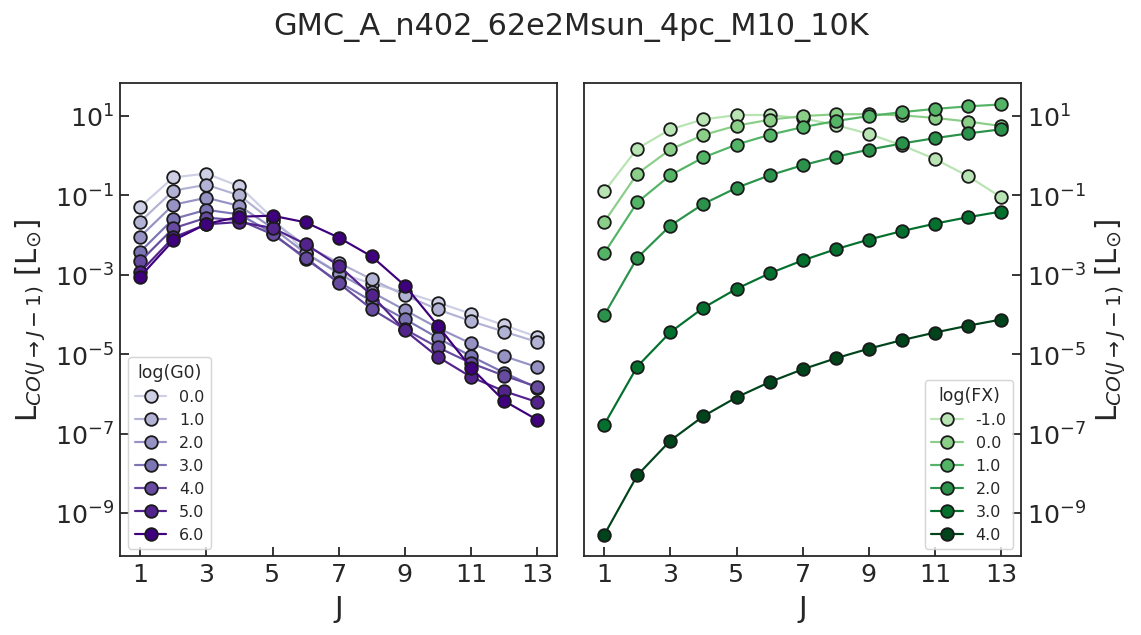

In [9]:
from gmc_module import *
gmc = gmcA

gmc.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

# A faster way to extract interpolated CO SLEDs? <a class="anchor" id="fastinterp"></a>
([back to top](#toc))

#### The old code was doing the following steps:
1. Find the 2 closest hden to logn (Cloudy files for different densities are in different folders)

        hh = [hden[hden < logn].max(), hden[hden > logn].min()]

2. For every sampled flux value, list the 2 files with the 2 closest hden (here for G0)

        for g in gnames:
            ff = ['pdr_h' + ('%.2f' % h).replace('.', '') + '_' + g for h in hh]

3. For those 2 files, within the sww_check function: first we check if they're on the swwlist (sww = something went wrong, it's the Cloudy output message that stands for errors during the run), and if they are we find other nearby (in the logn - logF space) files

            Hsleds = np.array([sww_check(wd, fname, logNH, Jmax=Jmax)[2] for fname in ff])

4. Within the sww_check function, we call the interSLED function to calculate the interpolated SLED for the given logNH, and if needed (i.e. if the files with the wanted flux values are in the swwlist), we run the paramSLED function to calculate the interpolated SLED for the given flux value
        
                # this block is within the sww_check function
                if fname in sww:
                    SLEDs = np.array([interSLED(wd, f, logNH, Jmax=Jmax) for f in [f1, f2]])
                    iSLED = paramSLED(f1, f2, SLEDs, float(fname[-3:])/1e2, Jmax=Jmax)
                else:
                    iSLED = interSLED(wd, fname, logNH, Jmax=Jmax)
                    SLEDs = np.array([interSLED(wd, f, logNH, Jmax=Jmax) for f in [f1, f2]])

5. Finally, we have the 2 right files ff[0], ff[1], and their SLEDs at the given logNH. We can run the paramSLED function to calculate the interpolated SLED for the given logn

            thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn, Jmax=Jmax)


#### What can we do to make it faster and clearer:
1. We can use logR instead of logNH as the first quantity to interpolate, so we don't have to open everytime the `pdr` files but the just the `emis` files
2. We can generate, before all the loops, the swwlist, so we don't have to open everytime the `swwlist` file

These 2 changes make us gain ~10% of the time

In [1]:
from gmc_module import *
import time
import multiprocessing

gmc = GMC('Sachiel', M=2e3, R=2, rho0=mu*mp*300, Mach=20, T=10)
wd = '/media/phd/cloudy/ngmgrid/'
#ndf = gmc.extract_clumps(Rclump='jeans', bound='mass', save=True)
ndf = pd.read_csv(gmc.ndf)
len(ndf)

25

In [2]:
start_time = time.time()

gmc.generate_parallel_sled(wd, Jmax=30)

print("--- %s seconds ---" % (time.time() - start_time))

--- 76.51860904693604 seconds ---


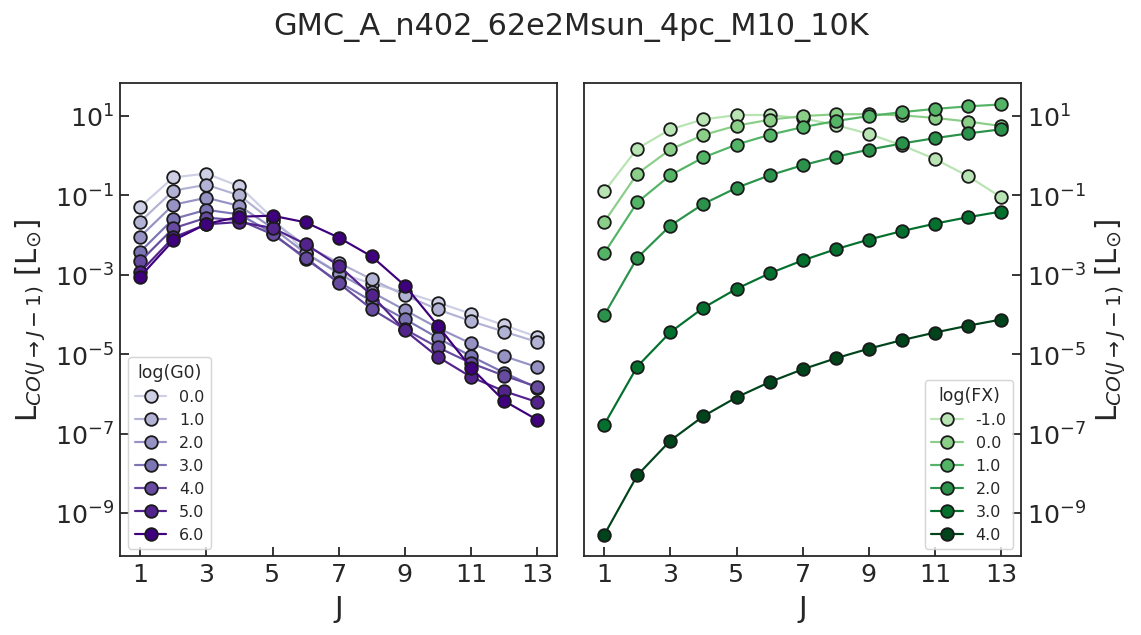

In [13]:
gmc = gmcA
gmc.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

In [4]:
start_time = time.time()

gmc.generate_clumps_sled(wd, Jmax=30)

print("--- %s seconds ---" % (time.time() - start_time))

--- 133.70291662216187 seconds ---


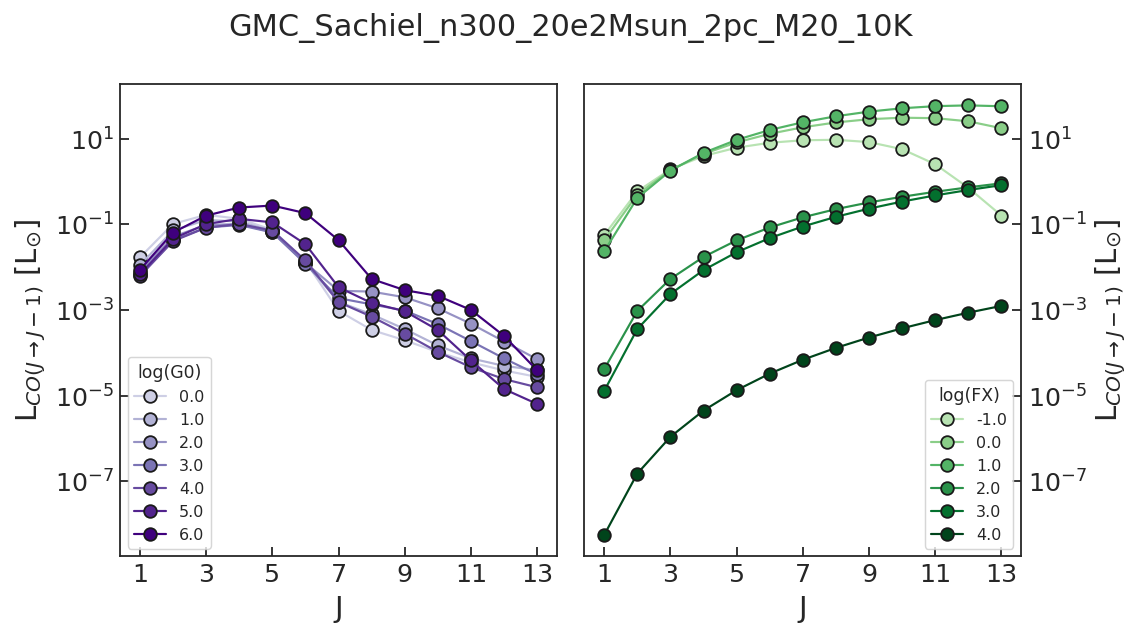

In [5]:
gmc.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

# UPDATE: Cloudy-sampled hden now starts from 0 instead of 1 <a class="anchor" id="new_hden"></a>
([back to top](#toc))

In [8]:
from gmc_module import *

# GMCs with the updated low Cloudy densities
gmcAlo = GMC('Alo', 6.2e3, 4, 8.2e-22, 10, T=10)
gmcBlo = GMC('Blo', 9.9e4, 16, 2.1e-22, 20, T=10)
gmcClo = GMC('C', 3.9e6, 100, 3.3e-23, 50, T=10)
gmcV19lo = GMC('V19', 1e5, 15, 6.122e-22, 10, T=10)

Alo Files not found: calculating them now


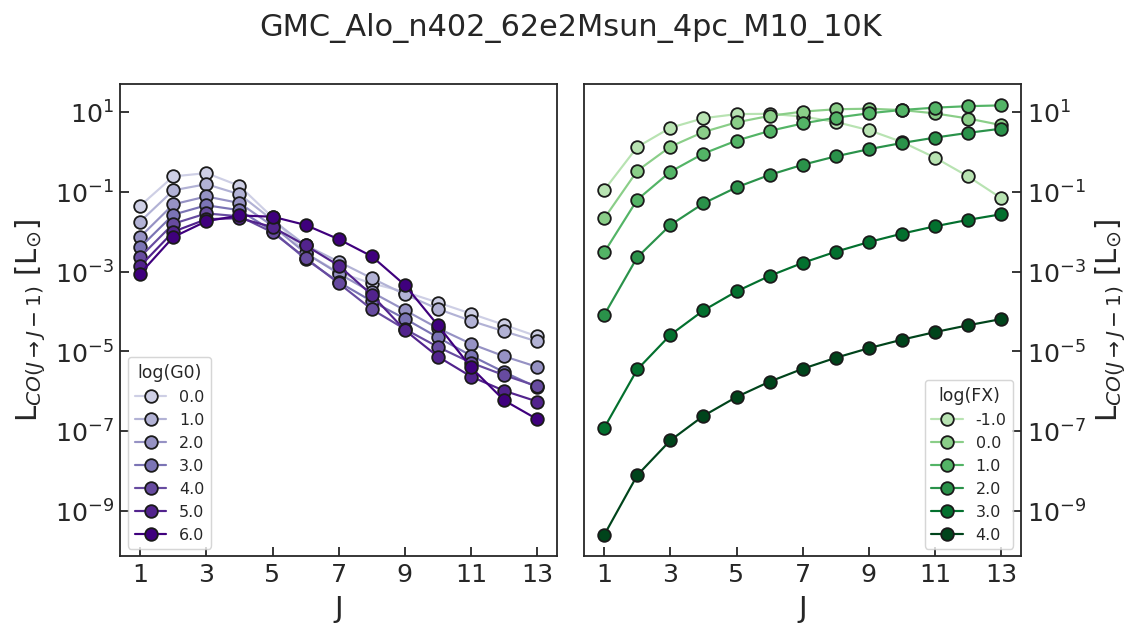

In [3]:
gmcAlo.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

To be compared with the previous extraction of this GMC:

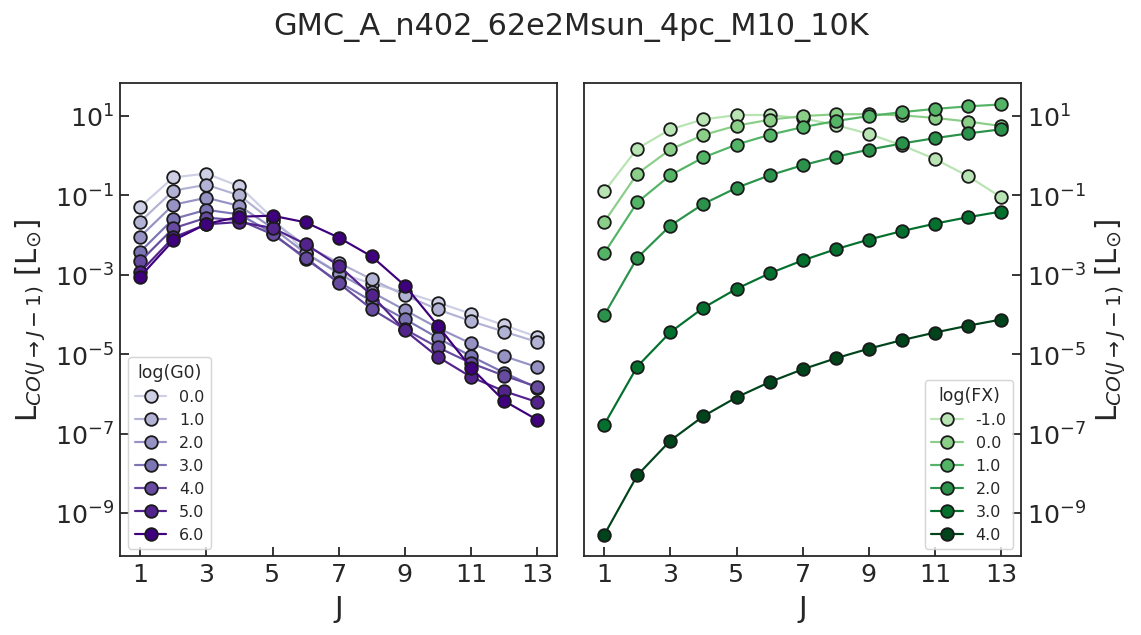

In [4]:
gmcA.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

Blo Files not found: calculating them now


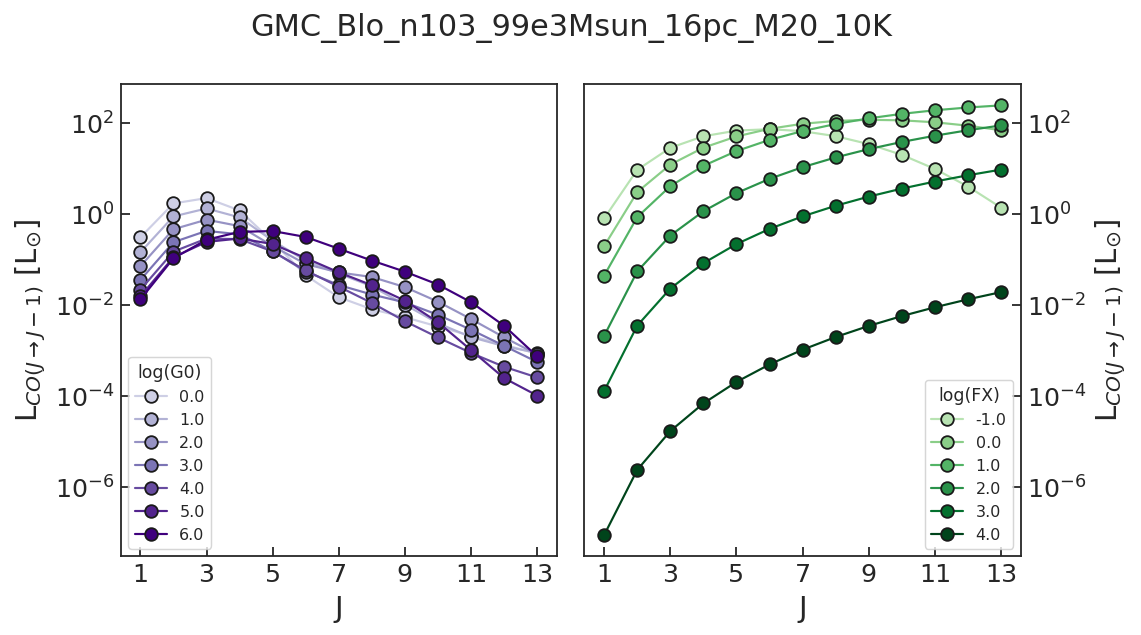

In [5]:
gmcBlo.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

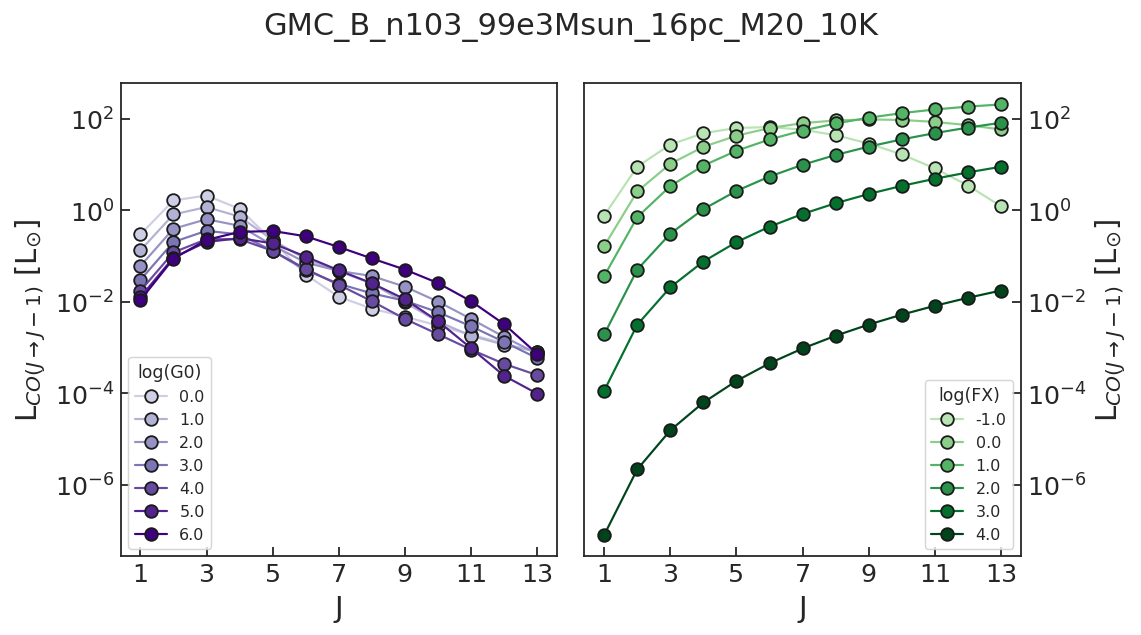

In [6]:
gmcB.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

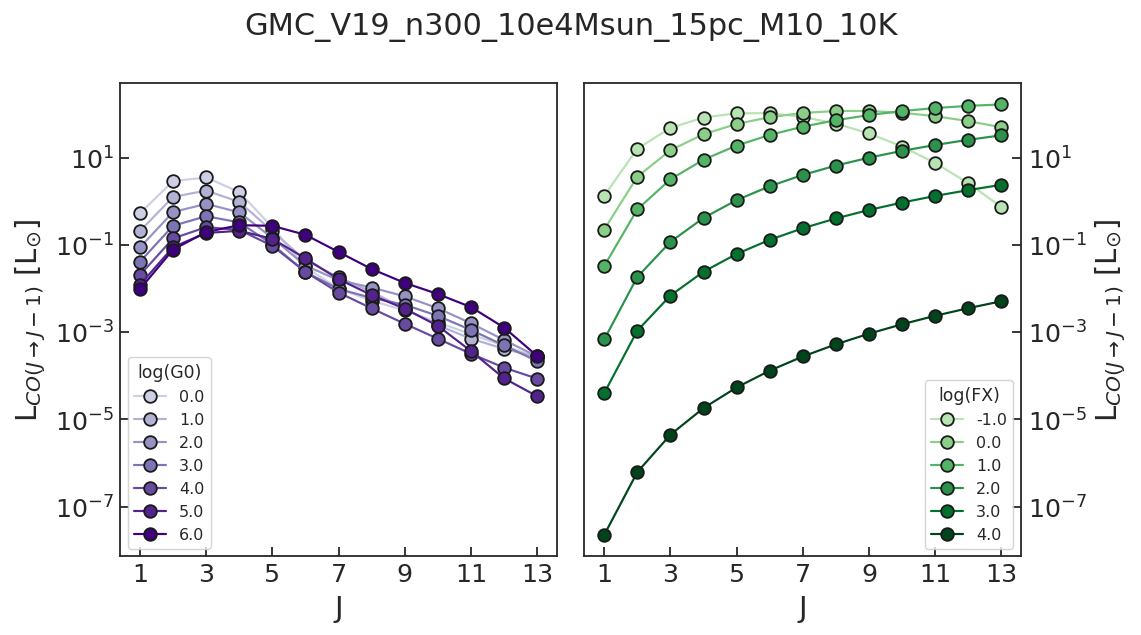

In [9]:
gmcV19lo.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

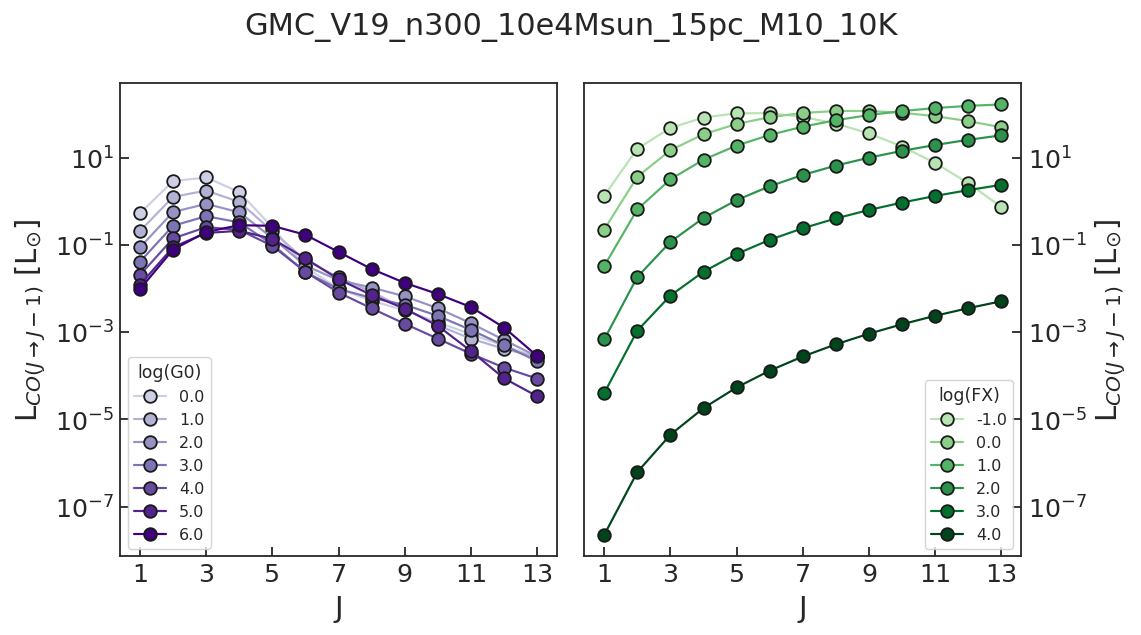

In [10]:
gmcV19.pdr_xdr_plot_SLED(Jmax=13, norm=0, save=False)

# PROBLEM: New turbogrid has problematic edges <a class="anchor" id="new_grid"></a>
([back to top](#toc))

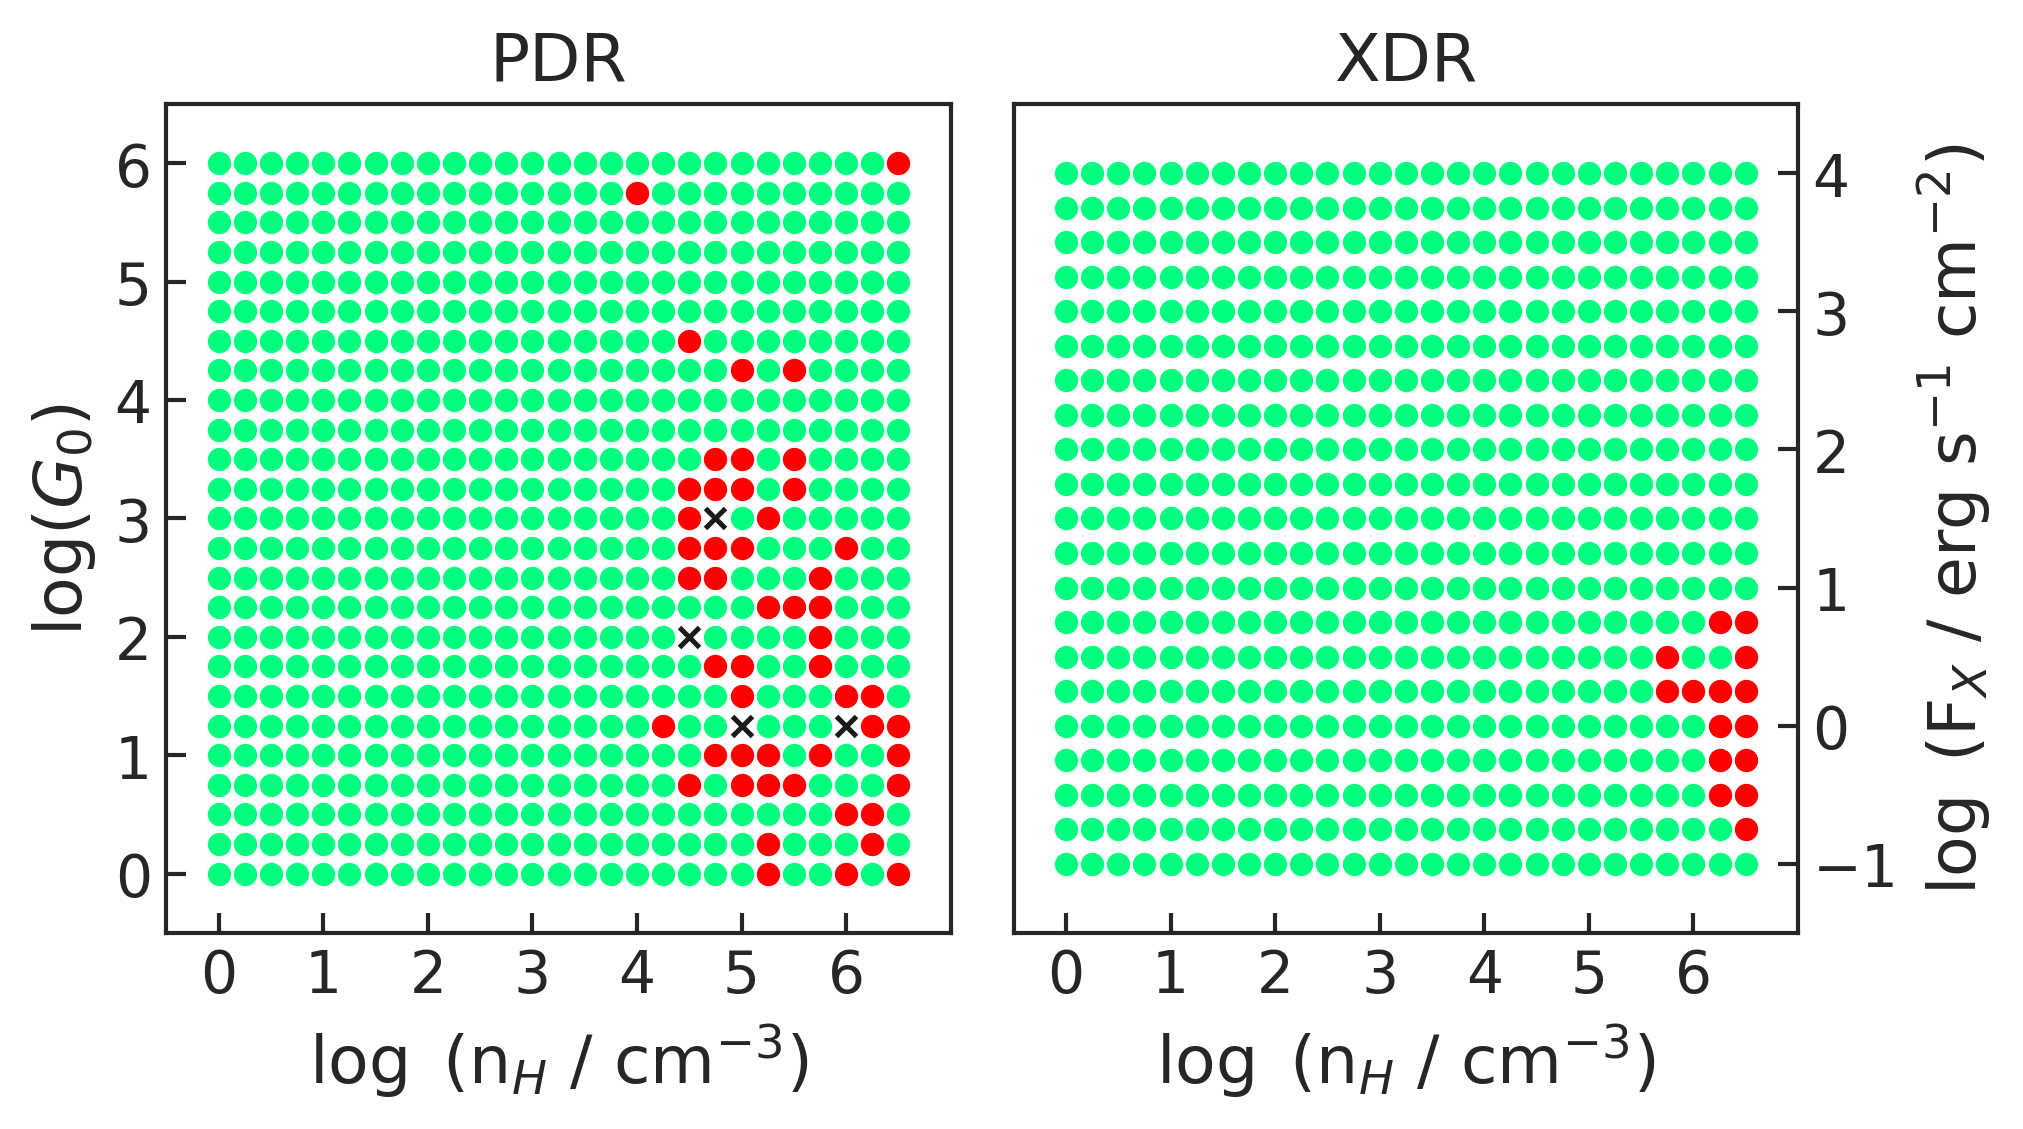

In [131]:
from IPython.display import Image, HTML
Image(filename='/media/phd/cloudy/turbogrid/grid_failures.png', width=700)

The functions contained in `gmc_module.py` will try to interpolate the fixed-density Cloudy runs to get the CO SLED of a clump with a randomly extracted gas density within the `hden` range. If the code finds a flagged Cloudy run (they are listed, for every grid, in a file named `swwlist.csv`), it will look for nearby runs in flux (the assumption here is that Cloudy runs differ less in fluxes than in densities) and interpolate between them.

What if there are no more nearby runs, i.e. the flagged Cloudy runs are on the edge of the parameter space? This is the situation with the `turbogrid`, as shown by the above plot.

1. Set to `np.nan` all the impossible-to-interpolate CO SLED

In [1]:
from gmc_module import *
wd = '/media/phd/cloudy/turbogrid/'

In [2]:
import time
import multiprocessing

gmc = gmcAturb
ndf = pd.read_csv(gmc.ndf)
len(ndf)

119

In [3]:
start_time = time.time()

gmc.generate_parallel_sled(wd, Jmax=30)

print("--- %s seconds ---" % (time.time() - start_time))

--- 357.5166292190552 seconds ---


#### Comparison of GMCs from `ngmgrid` and `turbogrid` <a class="anchor" id="compare_gmc_sleds"></a>

In [160]:
def compare_gmc_sleds(gmcs, Jmax=13, norm=0):
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(9,6), sharey=True, sharex=True)

    pdr_gmc, xdr_gmc = gmcs[0].pdr_xdr()
    color = cm.Purples(np.linspace(0.3, 1, len(pdr_gmc.index[::4])))
    for g, c in zip(pdr_gmc.index[::4], color):
        if norm: denom = pdr_gmc.loc[g, pdr_gmc.columns[norm-1]]
        else: denom = 1.
        ax1.plot(np.arange(1,Jmax+1), (pdr_gmc.loc[g]/denom)[:Jmax],
            marker='.', ms=14, mec='k', color=c,
            label=float(g[1:])/1e2)
    ax1.legend(title='log(G0)', loc='lower left', fontsize=6)
    color = cm.Greens(np.linspace(0.3, 1, len(xdr_gmc.index[::4])))
    for x, c in zip(xdr_gmc.index[::4], color):
        if norm: denom = xdr_gmc.loc[x, xdr_gmc.columns[norm-1]]
        else: denom = 1.
        ax2.plot(np.arange(1,Jmax+1), (xdr_gmc.loc[x]/denom)[:Jmax],
            marker='.', ms=14, mec='k', color=c, 
            label=float(x[1:])/1e2)
    ax2.legend(title='log(FX)', loc='lower right', fontsize=6)
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(labelright=True)
    for ax in [ax1, ax2]:
        ax.set_yscale('log')
        if norm:
            nlab = r'L$_{{CO({} \rightarrow {})}}$'.format(norm, norm-1)
            ax.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ / ' + nlab)
        else:
            ax.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ [L$_{\odot}$]')
    ax1.text(s=gmcs[0].name, x=0.75, y=0.85, transform=ax1.transAxes, size=10, backgroundcolor='y')

    pdr_gmc, xdr_gmc = gmcs[1].pdr_xdr()
    color = cm.Purples(np.linspace(0.3, 1, len(pdr_gmc.index[::4])))
    for g, c in zip(pdr_gmc.index[::4], color):
        if norm: denom = pdr_gmc.loc[g, pdr_gmc.columns[norm-1]]
        else: denom = 1.
        ax3.plot(np.arange(1,Jmax+1), (pdr_gmc.loc[g]/denom)[:Jmax],
            marker='.', ms=14, mec='k', color=c,
            label=float(g[1:])/1e2)
    ax3.legend(title='log(G0)', loc='lower left', fontsize=6)
    color = cm.Greens(np.linspace(0.3, 1, len(xdr_gmc.index[::4])))
    for x, c in zip(xdr_gmc.index[::4], color):
        if norm: denom = xdr_gmc.loc[x, xdr_gmc.columns[norm-1]]
        else: denom = 1.
        ax4.plot(np.arange(1,Jmax+1), (xdr_gmc.loc[x]/denom)[:Jmax],
            marker='.', ms=14, mec='k', color=c, 
            label=float(x[1:])/1e2)
    ax4.legend(title='log(FX)', loc='lower right', fontsize=6)
    ax4.yaxis.set_label_position('right')
    ax4.yaxis.tick_right()
    ax4.yaxis.set_tick_params(labelright=True)
    for ax in [ax3, ax4]:
        ax.set_xticks(np.arange(1,Jmax+1,2))
        ax.set_yscale('log')
        ax.set_xlabel('J')
        if norm:
            nlab = r'L$_{{CO({} \rightarrow {})}}$'.format(norm, norm-1)
            ax.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ / ' + nlab)
        else:
            ax.set_ylabel(r'L$_{CO(J \rightarrow J-1)}$ [L$_{\odot}$]')
    ax3.text(s=gmcs[1].name, x=0.75, y=0.85, transform=ax3.transAxes, size=10, backgroundcolor='y')

    fig.tight_layout();
    plt.show()

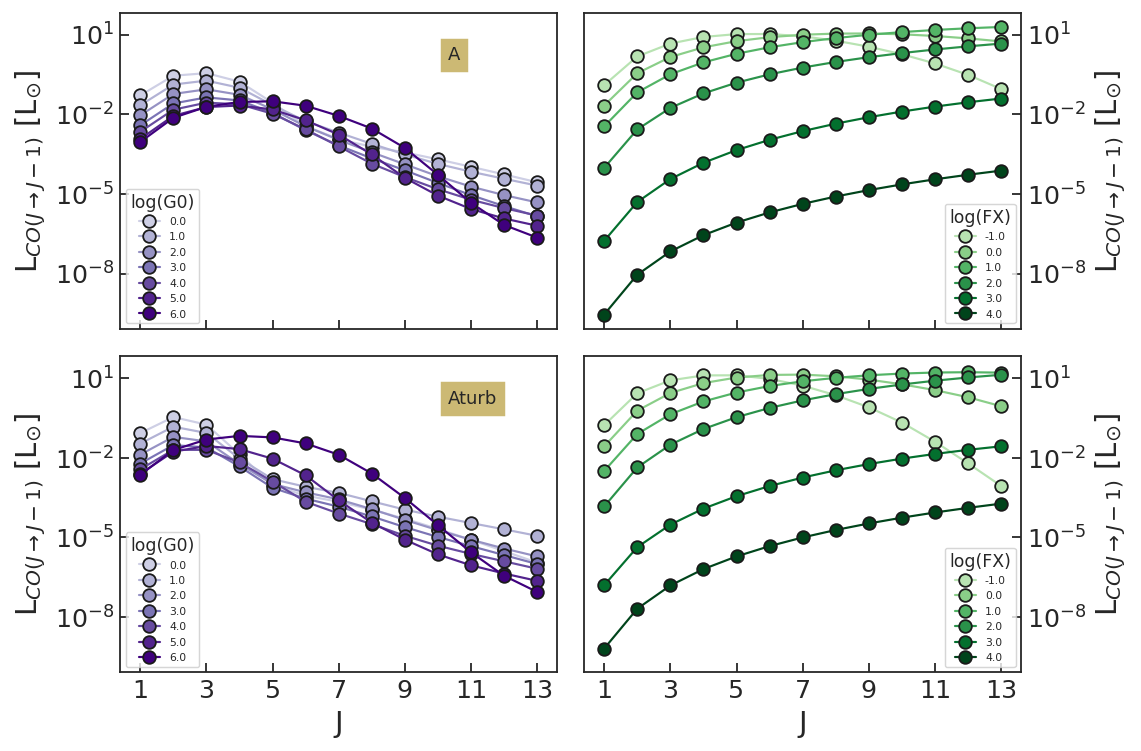

In [161]:
compare_gmc_sleds([gmcA, gmcAturb])

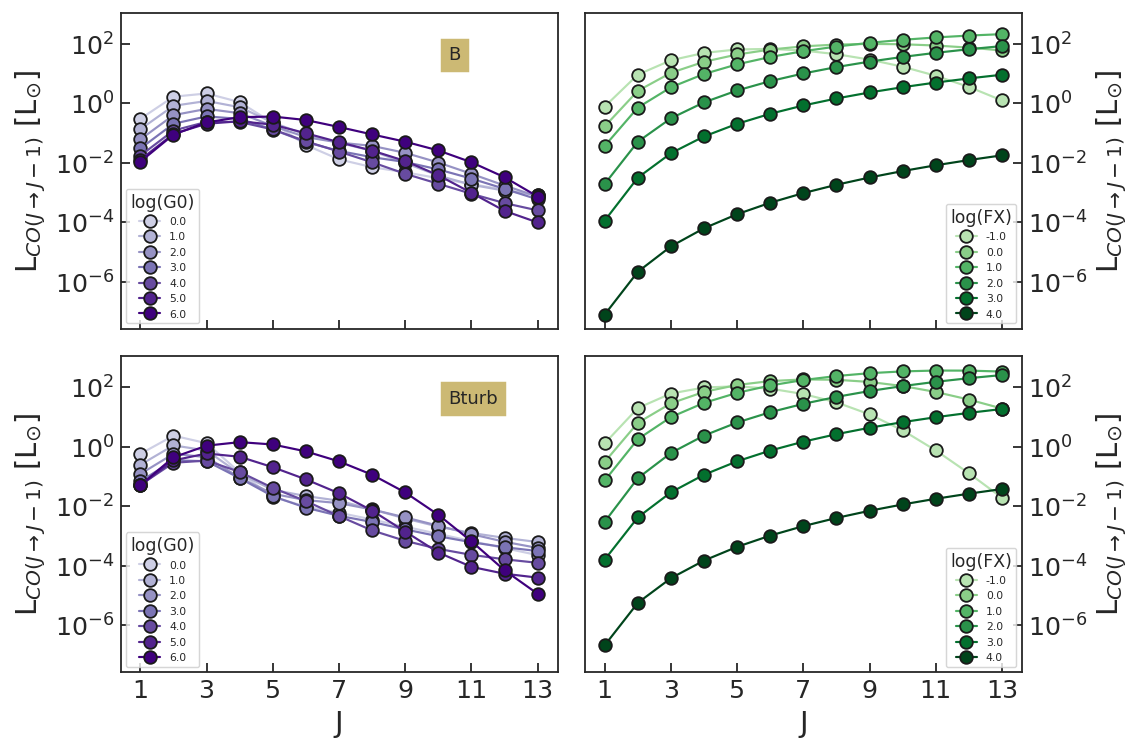

In [162]:
compare_gmc_sleds([gmcB, gmcBturb])

Cturb Files not found: calculating them now


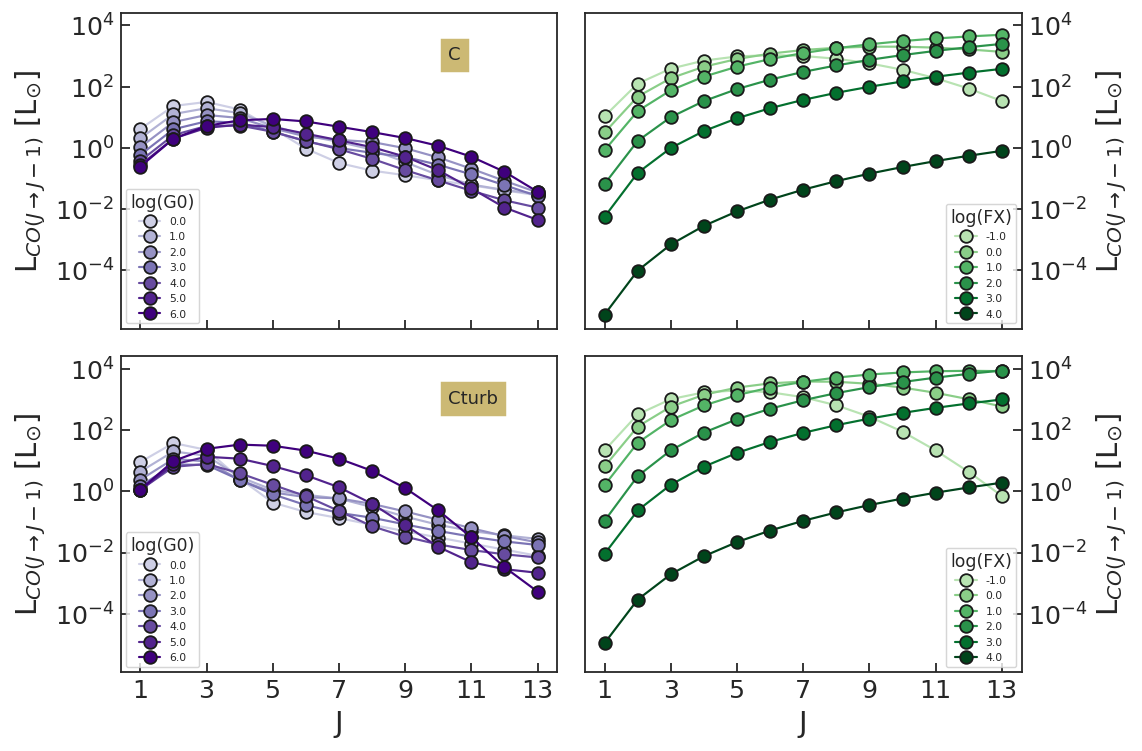

In [200]:
compare_gmc_sleds([gmcC, gmcCturb])

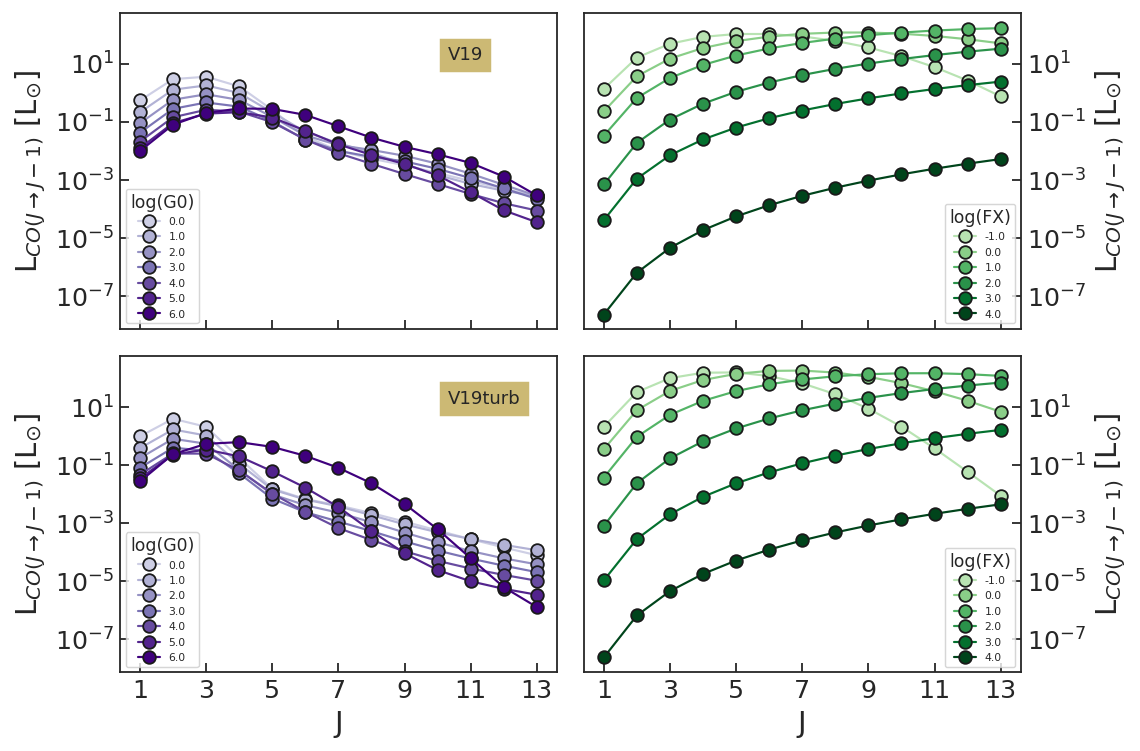

In [163]:
compare_gmc_sleds([gmcV19, gmcV19turb])

Now let's check how many clumps contain NaNs

In [172]:
for gmc in [gmcAturb, gmcBturb, gmcV19turb]:
    pdr_clumps, xdr_clumps = gmc.pdr_xdr_clumps()
    ndf = pd.read_csv(gmc.ndf)
    pdr_nan = sum([pdr_clumps[k].isnull().values.any().sum() for k in range(len(pdr_clumps))])
    xdr_nan = sum([xdr_clumps[k].isnull().values.any().sum() for k in range(len(xdr_clumps))])
    print('\nGMC ' + gmc.name + 
          ' has %2d clumps: missing %1d PDRs and %1d XDRs' % (len(pdr_clumps), pdr_nan, xdr_nan))
    for k in range(len(pdr_clumps)):
        pcheck = pdr_clumps[k].isnull().values.any()
        xcheck = xdr_clumps[k].isnull().values.any()
        if any([pcheck, xcheck]):
            plist = list(set(pdr_clumps[k].index) - set(pdr_clumps[k].dropna().index))
            xlist = list(set(xdr_clumps[k].index) - set(xdr_clumps[k].dropna().index))
            print(k, plist, xlist, 'log(n) = %.2f' % ndf.iloc[k]['hden'])


GMC Aturb has 113 clumps: missing 4 PDRs and 0 XDRs
13 ['g000', 'g025'] [] log(n) = 5.36
39 ['g000', 'g025'] [] log(n) = 5.01
45 ['g000', 'g025'] [] log(n) = 5.20
63 ['g000', 'g025'] [] log(n) = 5.38

GMC Bturb has 1212 clumps: missing 54 PDRs and 0 XDRs
2 ['g000'] [] log(n) = 5.83
5 ['g000', 'g025'] [] log(n) = 5.18
34 ['g000', 'g025'] [] log(n) = 5.11
42 ['g000', 'g025'] [] log(n) = 5.14
56 ['g000', 'g025'] [] log(n) = 5.11
69 ['g000', 'g025'] [] log(n) = 5.06
106 ['g000', 'g600'] [] log(n) = 6.34
115 ['g000'] [] log(n) = 6.04
150 ['g000', 'g025'] [] log(n) = 5.04
162 ['g000', 'g025'] [] log(n) = 5.20
180 ['g000', 'g025'] [] log(n) = 5.15
194 ['g000', 'g025'] [] log(n) = 5.05
210 ['g000'] [] log(n) = 5.95
215 ['g000'] [] log(n) = 6.06
219 ['g000', 'g025'] [] log(n) = 5.36
272 ['g000', 'g025'] [] log(n) = 5.18
310 ['g000', 'g025'] [] log(n) = 5.40
331 ['g000', 'g025'] [] log(n) = 5.30
334 ['g000', 'g025'] [] log(n) = 5.33
379 ['g000', 'g025'] [] log(n) = 5.45
420 ['g000', 'g025'] [] 

# Looking for CO (1-0) luminosity <a class="anchor" id="CO1"></a>
([back to top](#toc))

In [5]:
from gmc_module import *

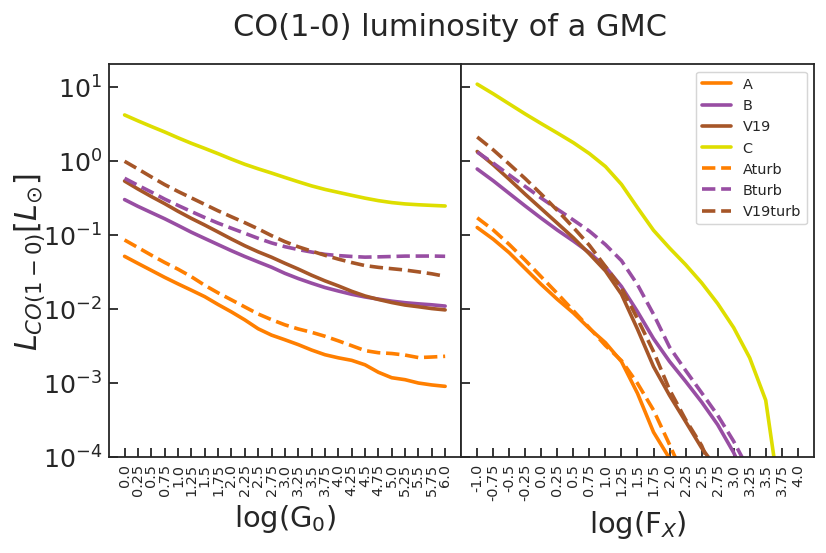

In [198]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(7,4), sharey=True)

gmcs1 = [gmcA, gmcB, gmcV19, gmcC]
gmcs2 = [gmcAturb, gmcBturb, gmcV19turb]

CBlist = ['#ff7f00', '#984ea3', '#a65628', '#dede00', '#f781bf', '#999999', '984ea3']
CBlist2 = ['#332288', '#44aa99', '#117733', '#999933', '#88ccee',
           '#ddcc77', '#cc6677', '#882255', '#aa4499', '#ddddd']

for gmc, c in zip(gmcs1, CBlist[:len(gmcs1)]):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr()
    ax1.plot(pdr_gmc.index, pdr_gmc['CO1'], lw=2, color=c, label=gmc.name)
    ax2.plot(xdr_gmc.index, xdr_gmc['CO1'], lw=2, color=c, label=gmc.name)

for gmc, c in zip(gmcs2, CBlist[:len(gmcs2)]):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr()
    ax1.plot(pdr_gmc.index, pdr_gmc['CO1'], lw=2, ls='--', color=c, label=gmc.name)
    ax2.plot(xdr_gmc.index, xdr_gmc['CO1'], lw=2, ls='--', color=c, label=gmc.name)


ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(np.arange(0,6.1,0.25), rotation=90, size=8)
ax1.set_xlabel(r'log(G$_0$)')

ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(np.arange(-1,4.2,0.25), rotation=90, size=8)
ax2.set_xlabel(r'log(F$_X$)')
ax2.legend(loc='upper right', fontsize=8);

for ax in [ax1, ax2]:
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 2e1])

plt.subplots_adjust(wspace=0)
fig.suptitle('CO(1-0) luminosity of a GMC')
fig.supylabel(r'$L_{CO(1-0)} [L_{\odot}]$');

In [55]:
for gmc in gmclist:
    wd = gmc.wd
    ndf = pd.read_csv(gmc.ndf)
    print('\n' + gmc.name, '; Nclumps =', len(ndf))
    Rgmc = gmc.R
    Ricm = 10**(ndf.iloc[-1].logR)
    Rclu = '%.4f' % 10**(ndf.iloc[:-1].logR.min()) + ' - ' + '%.2f' % 10**(ndf.iloc[:-1].logR.max())
    print('Rgmc =', Rgmc, 'pc; Rclumps =', Rclu, 'pc; Ricm = %.2f' % Ricm, 'pc')
    pdr_df, xdr_df = [], []
    for n in ndf['hden'].sort_values().index:
        fPDR = pd.read_csv(gmc.ndf.replace('.csv', '') + '_PDR{:04d}'.format(n) + '.csv', index_col=0)
        fXDR = pd.read_csv(gmc.ndf.replace('.csv', '') + '_XDR{:04d}'.format(n) + '.csv', index_col=0)
        logR_cm = ndf.loc[n, 'logR'] + np.log10(pc)
        pdr_df.append(fPDR['CO1'] * 2*np.pi*(10**logR_cm)**2 / lsun)
        xdr_df.append(fXDR['CO1'] * 2*np.pi*(10**logR_cm)**2 / lsun)
    pdr_CO1 = pd.DataFrame(index=ndf['hden'].sort_values().to_list(), data=pdr_df)
    xdr_CO1 = pd.DataFrame(index=ndf['hden'].sort_values().to_list(), data=xdr_df)
    pdr_CO1.to_csv(gmc.wd + gmc.ndf_name.replace('GMC', 'PDR_CO1') + '.csv')
    xdr_CO1.to_csv(gmc.wd + gmc.ndf_name.replace('GMC', 'XDR_CO1') + '.csv')


A ; Nclumps = 122
Rgmc = 4 pc; Rclumps = 0.0488 - 1.30 pc; Ricm = 2.36 pc

B ; Nclumps = 1178
Rgmc = 16 pc; Rclumps = 0.0149 - 2.57 pc; Ricm = 10.46 pc

C ; Nclumps = 22463
Rgmc = 100 pc; Rclumps = 0.0147 - 6.49 pc; Ricm = 73.05 pc

V19 ; Nclumps = 1555
Rgmc = 15 pc; Rclumps = 0.0157 - 1.51 pc; Ricm = 13.05 pc


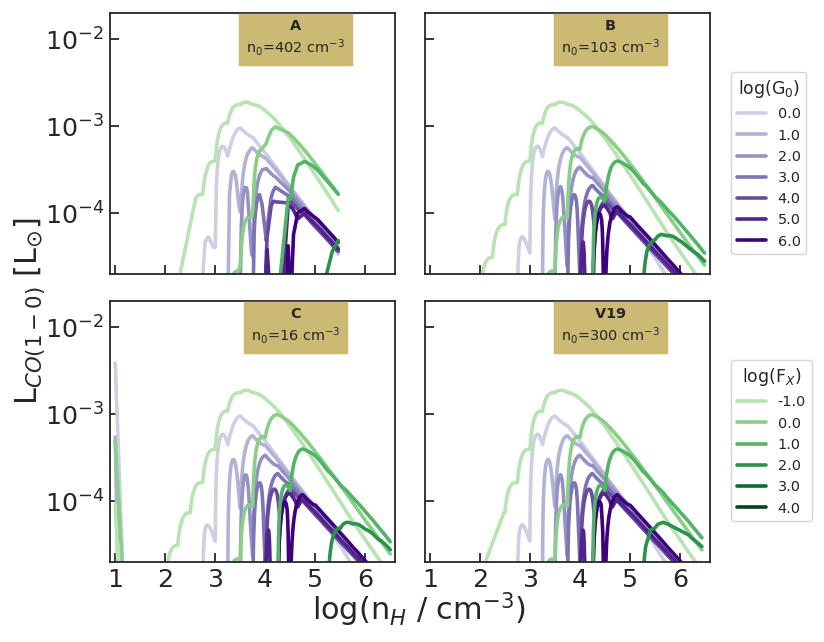

In [57]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(6.5,5), sharex=True, sharey=True)

for ax, gmc in zip([ax1, ax2, ax3, ax4], gmclist):
    pdr_CO1 = pd.read_csv(gmc.wd + gmc.ndf_name.replace('GMC', 'PDR_CO1') + '.csv', index_col=0)
    xdr_CO1 = pd.read_csv(gmc.wd + gmc.ndf_name.replace('GMC', 'XDR_CO1') + '.csv', index_col=0)
    pdr_plots, xdr_plots = [], []
    
    for gg, c in zip(pdr_CO1.columns[::4], cm.Purples(np.linspace(0.3, 1, len(pdr_CO1.columns[::4])))):
        p1, = ax.plot(pdr_CO1.index, pdr_CO1[gg], lw=2, color=c, label=int(gg[1:])/1e2)
        pdr_plots.append(p1)

    for xx, c in zip(xdr_CO1.columns[::4], cm.Greens(np.linspace(0.3, 1, len(xdr_CO1.columns[::4])))):
        p2, = ax.plot(xdr_CO1.index, xdr_CO1[xx], lw=2, color=c, label=int(xx[1:])/1e2)
        xdr_plots.append(p2)
    
    ax.text(x=0.65, y=0.85, transform=ax.transAxes, size=8, backgroundcolor='y', ha='center', 
            s= r'$\bf{' + gmc.name + '}$' + '\n' + r'n$_0$=' + '%.0f' % (gmc.n0) + r' cm$^{-3}$')
            
    ax.set_yscale('log')
    ax.set_ylim([2e-5, 2e-2])
    ax.set_xlim([0.9, 6.6])
    ax.set_xticks(np.arange(1,7,1))

ax2.legend(handles=pdr_plots, fontsize=8, title=r'log(G$_0$)', bbox_to_anchor=[1.05, 0.8])
ax4.legend(handles=xdr_plots, fontsize=8, title=r'log(F$_X$)', bbox_to_anchor=[1.05, 0.8])

plt.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout(rect=(0.025,0.025,1,1))
fig.supxlabel(r'log(n$_H$ / cm$^{-3}$)')
fig.supylabel(r'L$_{CO(1-0)}$ [L$_{\odot}$]');

# Looking for a different clumps mass <a class="anchor" id="clump_mass"></a>
([back to top](#toc))

In [10]:
from gmc_module import *

Within this module we have set

`mu = 1.22
gamma = 5/3`

and we have the `jeans(n, T)` function, that returns the Jeans radius (in pc) and mass (in Msun)

In [11]:
print('The median (in density) GMC clump has')
for gmc in gmclist:
    medn = 10**pd.read_csv(gmc.ndf)['hden'].median()
    print('GMC ' + gmc.name + ': R = %.1e pc, M = %.1e Msun' % jeans(n=medn, T=10))

The median (in density) GMC clump has
GMC A: R = 5.6e-01 pc, M = 4.8e+01 Msun
GMC B: R = 8.0e-01 pc, M = 6.9e+01 Msun
GMC C: R = 1.0e+00 pc, M = 9.0e+01 Msun
GMC V19: R = 6.8e-01 pc, M = 5.9e+01 Msun


Let's see how they compare with the different masses estimated [here](http://www.astro.yale.edu/vdbosch/astro610_lecture16.pdf)

In [13]:
mu = 1.22
gamma = 1
T = 10
sigma_v = 1.5e5 # this is the turbulent velocity set in Cloudy

def jeans(n, T): # return Jeans radius in pc and mass in Msun
    rho = n * mu * mp
    cs = np.sqrt(1 * kb * T / (mu * mp))
    RJ = 0.5 * cs * np.sqrt(pi / (G * rho))
    MJ = (4/3) * pi * rho * RJ**3 / msun
    return RJ/pc, MJ

def MJalt(n, T):
    cs2 = kb * T / (mu * mp)
    rho = mu*mp*n
    return (5 * cs2 / G)**(3/2) * np.sqrt(3/(4*pi*rho))

def MBE(n, T):
    cs3 = (kb * T / (mu * mp))**(3/2)
    rho = mu*mp*n
    return 1.182 * cs3 / np.sqrt(rho * G**3)

def MJturb(n, T, sigma_v):
    rho = n * mu * mp
    cs2 = kb * T / (mu * mp)
    cs_turb = np.sqrt(cs2 + sigma_v**2)
    RJ = cs_turb * np.sqrt(pi / (G * rho))
    MJ = (4/3) * pi * rho * RJ**3 / msun
    return MJ

def Mmckee(n, T):
    rho = mu*mp*n
    cs = np.sqrt(kb * T / (mu * mp))
    return (pi**(5/2)/6) * cs**3 / ((G**(3/2)) * (rho**(1/2)))

print('The median (in density) GMC clump has')
for gmc in gmclist:
    medn = 10**pd.read_csv(gmc.ndf)['hden'].median()
    print('\nGMC ' + gmc.name + ': median density = %.1e cm-3' % medn)
    print('My Jeans mass = ', jeans(n=medn, T=10)[1])
    print('alt-Jeans mass = ', MJalt(n=medn, T=10)/msun)
    print('Bonnor-Ebert mass = ', MBE(n=medn, T=10)/msun)
    print('Turbulent Jeans mass = ', MJturb(n=medn, T=10, sigma_v=1.5e5))
    print('McKee Jeans mass = ', Mmckee(n=medn, T=10)/msun)

The median (in density) GMC clump has

GMC A: median density = 2.2e+03 cm-3
My Jeans mass =  22.31647900144539
alt-Jeans mass =  41.813155644144466
Bonnor-Ebert mass =  9.047315173862843
Turbulent Jeans mass =  35817.1097225801
McKee Jeans mass =  22.316479001445398

GMC B: median density = 1.1e+03 cm-3
My Jeans mass =  32.20138712941016
alt-Jeans mass =  60.333962714824786
Bonnor-Ebert mass =  13.054751978413568
Turbulent Jeans mass =  51682.01560643423
McKee Jeans mass =  32.20138712941015

GMC C: median density = 6.2e+02 cm-3
My Jeans mass =  41.99191441745894
alt-Jeans mass =  78.67793361215645
Bonnor-Ebert mass =  17.023925882932506
Turbulent Jeans mass =  67395.44379083758
McKee Jeans mass =  41.99191441745894

GMC V19: median density = 1.5e+03 cm-3
My Jeans mass =  27.380969401369693
alt-Jeans mass =  51.30221193015602
Bonnor-Ebert mass =  11.100508280183519
Turbulent Jeans mass =  43945.426395263705
McKee Jeans mass =  27.380969401369697


# Which clump dominates the CO SLED of GMC-V19? <a class="anchor" id="clump_dom"></a>
([back to top](#toc))

In [1]:
from gmc_module import *

`gmcV19` and `gmcV20` are just two different extractions of the same identical cloud (the fiducial one from Vallini+2019). Here we plot their CO SLEDs, and as we can see there are no appreciable differences (if we check the numbers there are slight differences, just to ensure that they are not really identical).

The function to compare CO SLEDs from 2 GMCs has been defined [here](#compare_gmc_sleds)

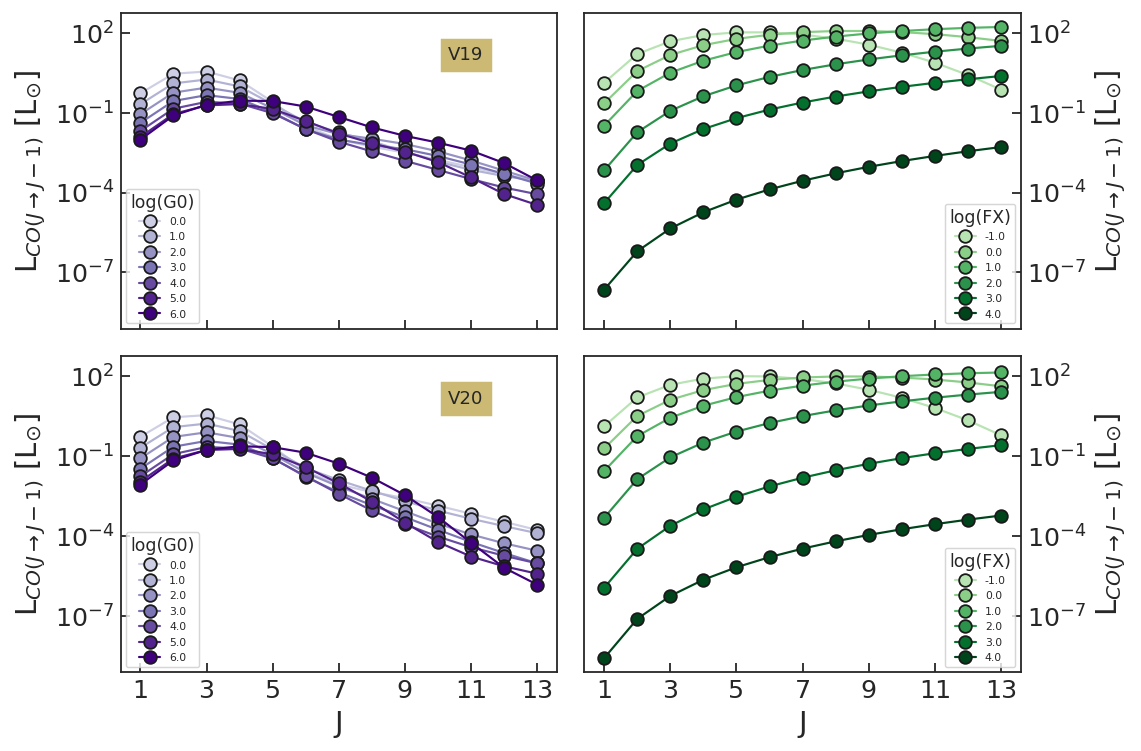

In [199]:
compare_gmc_sleds([gmcV19, gmcV20])

Let's check the clumps that constitute `gmcV19`, to see if one is dominant. To do it, we use the `gmc.pdr_xdr_clumps()` function, which then will return 2 lists of DataFrames, in which every element is the CO SLED of the single clump in $L_{\odot}$ units, instead of the CO SLED of the whole GMC obtained with the `gmc.pdr_xdr()` function (which is just the sum of every clump)

In [18]:
from gmc_module import *
gmc = gmcV19
pdr_df, xdr_df = gmc.pdr_xdr_clumps()

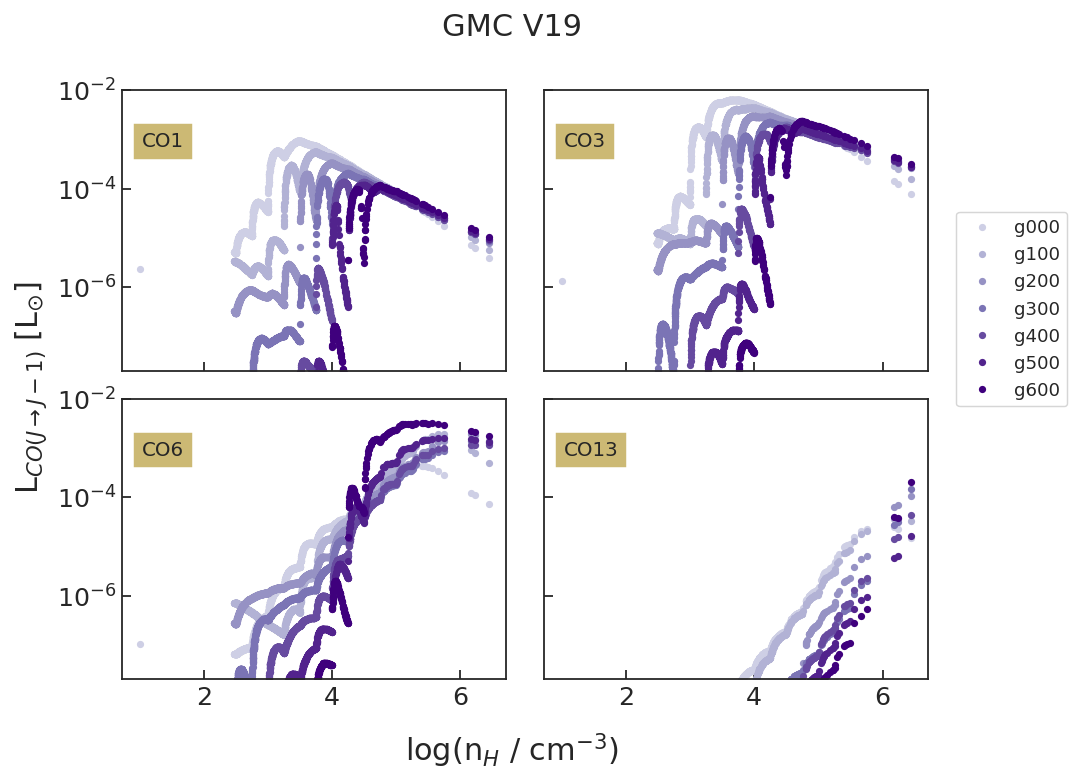

In [51]:
colines = ['CO1', 'CO3', 'CO6', 'CO13']
ndf = pd.read_csv(gmc.ndf)

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(8,6), sharey=True, sharex=True)

for ax, line in zip([ax1, ax2, ax3, ax4], colines):
    for g, c in zip(gnames[::-4], cm.Purples(np.linspace(0.3, 1, len(gnames[::4])))):
        ax.plot(ndf['hden'], [pdr_g0.loc[g, line] for pdr_g0 in pdr_df],
                color = c, marker='.', ms=6, ls='', label=g)
    #for x, c in zip(xnames[::-4], cm.Greens(np.linspace(0.3, 1, len(xnames[::4])))):
    #    ax.plot(ndf['hden'], [xdr_fx.loc[x, line] for xdr_fx in xdr_df],
    #            color = c, marker='.', ms=6, ls='', label=x)
    ax.set_yscale('log')
    ax.set_ylim([2e-8, 1e-2])
    ax.text(s=line, x=0.05, y=0.8, transform=ax.transAxes, size=11, backgroundcolor='y')

fig.supylabel(r'L$_{CO(J \rightarrow J-1)}$ [L$_{\odot}$]')
fig.supxlabel(r'log(n$_H$ / cm$^{-3}$)')
fig.suptitle('GMC ' + gmc.name)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
ax2.legend(bbox_to_anchor=(1.05, 0.6), fontsize=10);

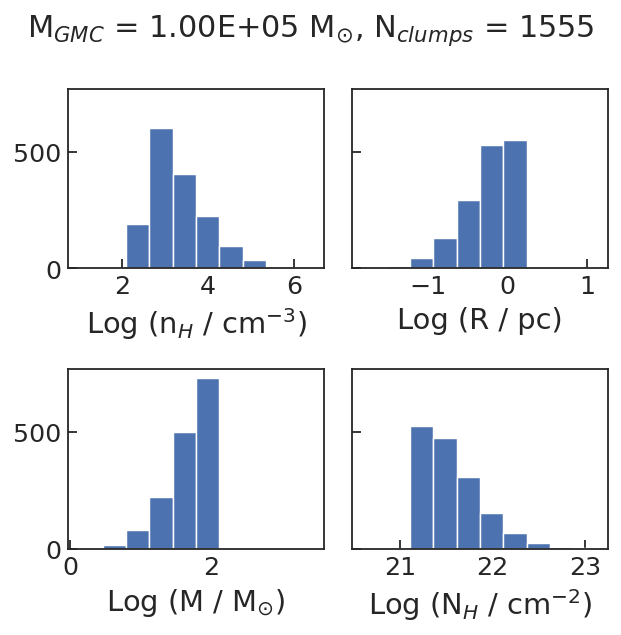

In [47]:
ndf_histo(ndf)

# Adding diffuse ICM to the GMC <a class="anchor" id="diffuse"></a>
([back to top](#toc))

In [1]:
from gmc_module import *

We have added new Cloudy runs at very low densities, extending the parameter space down to $n_H = 1$ cm$^{-3}$. This extension will affect the clumps extractions of our GMCs only for the last clump, the ICM one, which is limited by the lowest Cloudy sampled density (now 1 cm$^{-3}$, while before it was 10 cm$^{-3}$). The other clumps densities are instead limited by the $n_0$ quantity, which is unique for each GMC, and it has always been set $n_0 > 10$ cm$^{-3}$.

Down here we refer to `lo` for the new extractions ($n_{ICM} \geq 1$ cm$^{-3}$). What we try to do is to subtract the ICM clump from each GMC within a median galaxy, and to spread this molecular mass over the whole galaxy (i.e. over a volume $V = \pi r_{CO}^2 z_{CO}$) to calculate its $n$ and $N_H$.

In [9]:
Mtot = df.Mmol_tot_XMW.median()
rCO = df.rCO.median() * kpc
zCO = rCO * 0.01/0.17
print('\nUsing the median values for the 35 AGN sample:')
print('Total molecular mass = %.1e Msun' % Mtot)
print('rCO = %.2f kpc    zCO = %.2f pc' % (rCO/kpc, zCO/pc))

gmcnames = [gmc.name for gmc in gmclist + gmclost]
cols = ['Mgmc', 'Nclumps', 'Ngmc', 'Micm', 'n_icm', 'logNH']
icm = pd.DataFrame(index=gmcnames, columns=cols)
for gmc in gmclist + gmclost:
    ndf = pd.read_csv(gmc.ndf)
    logMicm = ndf.iloc[-1]['logM']
    M_icm_gal = (10**logMicm) * Mtot / gmc.M
    n_icm = (msun*M_icm_gal / (zCO * pi*(rCO)**2)) / (mu*mp)
    icm.loc[gmc.name, 'Mgmc'] = gmc.M
    icm.loc[gmc.name, 'Nclumps'] = len(ndf)
    icm.loc[gmc.name, 'Ngmc'] = (Mtot / gmc.M)
    icm.loc[gmc.name, 'Micm'] = (10**logMicm) * Mtot / gmc.M
    icm.loc[gmc.name, 'n_icm'] = n_icm
    icm.loc[gmc.name, 'logNH'] = np.log10(n_icm * rCO)

icm


Using the median values for the 35 AGN sample:
Total molecular mass = 2.2e+10 Msun
rCO = 3.07 kpc    zCO = 180.50 pc


,Mgmc,Nclumps,Ngmc,Micm,n_icm,logNH
A,6200,122,3.57997e+06,1.14307e+08,0.710447,21.8278
B,99000,1178,224200,3.45834e+08,2.14945,22.3086
C,3.9e+06,22463,5691.24,2.80077e+09,17.4075,23.217
V19,100000,1555,221958,6.2405e+08,3.87863,22.565
Alo,6200,116,3.57997e+06,2.25001e+07,0.139844,21.122
Blo,99000,1219,224200,4.31555e+07,0.268223,21.4048
Clo,3.9e+06,25298,5691.24,2.17131e+08,1.34953,22.1065
V19lo,100000,1561,221958,6.34447e+07,0.394325,21.5722


Let's calculate the CO SLEDs of these spread ICMs. 

Since some ICM densities are below 1 cm$^{-3}$ we force them to be at least $10^{0.01}$ cm$^{-3}$ 
with the command `if logn < 0: logn = 0.01`
(putting $10^0$ cm$^{-3}$ would result in an error, 
since the interpolation cannot work -yet- with precisely the same of values of the sampled ones)

In [16]:
# the radius for extracting the Cloudy output
logR = np.log10(df.rCO.median() * kpc)

# save the results
pwrt = '/media/phd/jupyter/claudia/icm_sleds/'
exbase = pwrt + 'icmSLED_'

Jmax = 13
wd = '/media/phd/cloudy/ngmgrid/'
sww = pd.read_csv(wd + 'swwlist.csv', header=None)[0].to_list()
sww = [s.replace('.out', '') for s in sww]
COls = ['CO' + str(c) for c in np.arange(1,Jmax+1)]
pbar = ProgressBar()
for gmc in pbar(icm.index):
    logn = np.log10(icm.loc[gmc, 'n_icm'])
    if logn < 0: logn = 0.01
    hh = [hden[hden < logn].max(), hden[hden > logn].min()]
    extract = pd.DataFrame(index=gnames[::-1], columns=COls)
    for g in gnames:
        ff = ['pdr_h%03d_' % (h*1e2) + g for h in hh]
        Hsleds = np.array([sww_new(wd, fname, logR, sww, Jmax)[2] for fname in ff])
        thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn, Jmax)
        extract.loc[g] = np.array(thisSLED)
    extract = extract * 4*pi*(10**logR)**2 / lsun
    extract.to_csv(exbase + gmc + '_PDR.csv')
    extract = pd.DataFrame(index=xnames[::-1], columns=COls)
    for x in xnames:
        ff = ['xdr_h%03d_' % (h*1e2) + x for h in hh]
        Hsleds = np.array([sww_new(wd, fname, logR, sww, Jmax)[2] for fname in ff])
        thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn, Jmax)
        extract.loc[x] = np.array(thisSLED)
    extract = extract * 4*pi*(10**logR)**2 / lsun
    extract.to_csv(exbase + gmc + '_XDR.csv')

100% |#########################################################################|


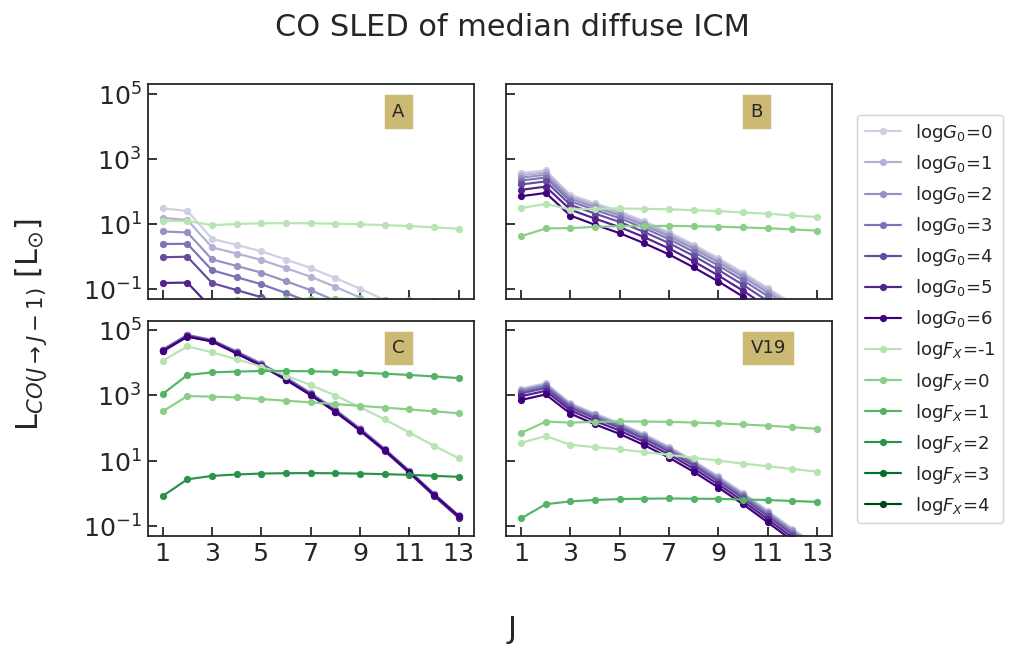

In [18]:
exbase = '/media/phd/jupyter/claudia/icm_sleds/icmSLED_'
pdr_df = [pd.read_csv(exbase + gmc + '_PDR.csv', index_col=0) for gmc in icm.index]
xdr_df = [pd.read_csv(exbase + gmc + '_XDR.csv', index_col=0) for gmc in icm.index]
Jmax = 13

fig, axes = plt.subplots(2, 2, figsize=(8,5), sharey=True, sharex=True)

for ax, k in zip(axes.flatten(), range(len(icm))[:4]):
    gmc = icm.index[k]
    # PDR
    pdr = pdr_df[k]
    for g, c in zip(gnames[::-4], cm.Purples(np.linspace(0.3, 1, len(gnames[::4])))):
        ax.plot(np.arange(1,Jmax+1), pdr_df[k].loc[g], 
                color = c, marker='.', ms=6, label=r'log$G_0$=%1d' % (float(g[1:])/1e2))
    for x, c in zip(xnames[::-4], cm.Greens(np.linspace(0.3, 1, len(xnames[::4])))):
        ax.plot(np.arange(1,Jmax+1), xdr_df[k].loc[x], 
                color = c, marker='.', ms=6, label=r'log$F_X$=%1d' % (float(x[1:])/1e2))
    ax.set_yscale('log')
    ax.set_ylim([0.5e-1, 2e5])
    ax.set_yticks([1e-1,1e1,1e3,1e5])
    ax.set_xticks(np.arange(1,Jmax+1,2))
    ax.text(s=gmc, x=0.75, y=0.85, transform=ax.transAxes, size=10, backgroundcolor='y')

fig.supylabel(r'L$_{CO(J \rightarrow J-1)}$ [L$_{\odot}$]')
fig.supxlabel(r'J')
fig.suptitle('CO SLED of median diffuse ICM')
axes.flatten()[1].legend(bbox_to_anchor=(1.05, 0.9), fontsize=10)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1);